In [1]:
import numpy as np
from scipy.signal import lfilter, firwin
from pylab import *
from scipy.fftpack import fft,fftshift
import scipy.signal as signal
from tool._fixedInt import *

In [2]:
#------------------------------------------------
# Create a signal for demonstration.
#------------------------------------------------
# 320 samples of (1000Hz + 15000 Hz) at 48 kHz

sample_rate = 48000.
nsamples = 1024

F_1KHz = 1500.
A_1KHz = 1.0
 
F_15KHz = 17000.
A_15KHz = 0.5
 
t = np.arange(nsamples) / sample_rate

noise  = A_15KHz * np.sin(2*np.pi*F_15KHz*t)
data   = A_1KHz  * np.sin(2*np.pi*F_1KHz*t)
signal_gen = data + noise
 

# FFT
NFFT = 1024
fs = sample_rate

fft_signal     = fft(data,NFFT)
fft_signal_gen = fft(signal_gen,NFFT)
xfft           = np.linspace(0.0, 1.0/(2.0*t[1]), NFFT//2)

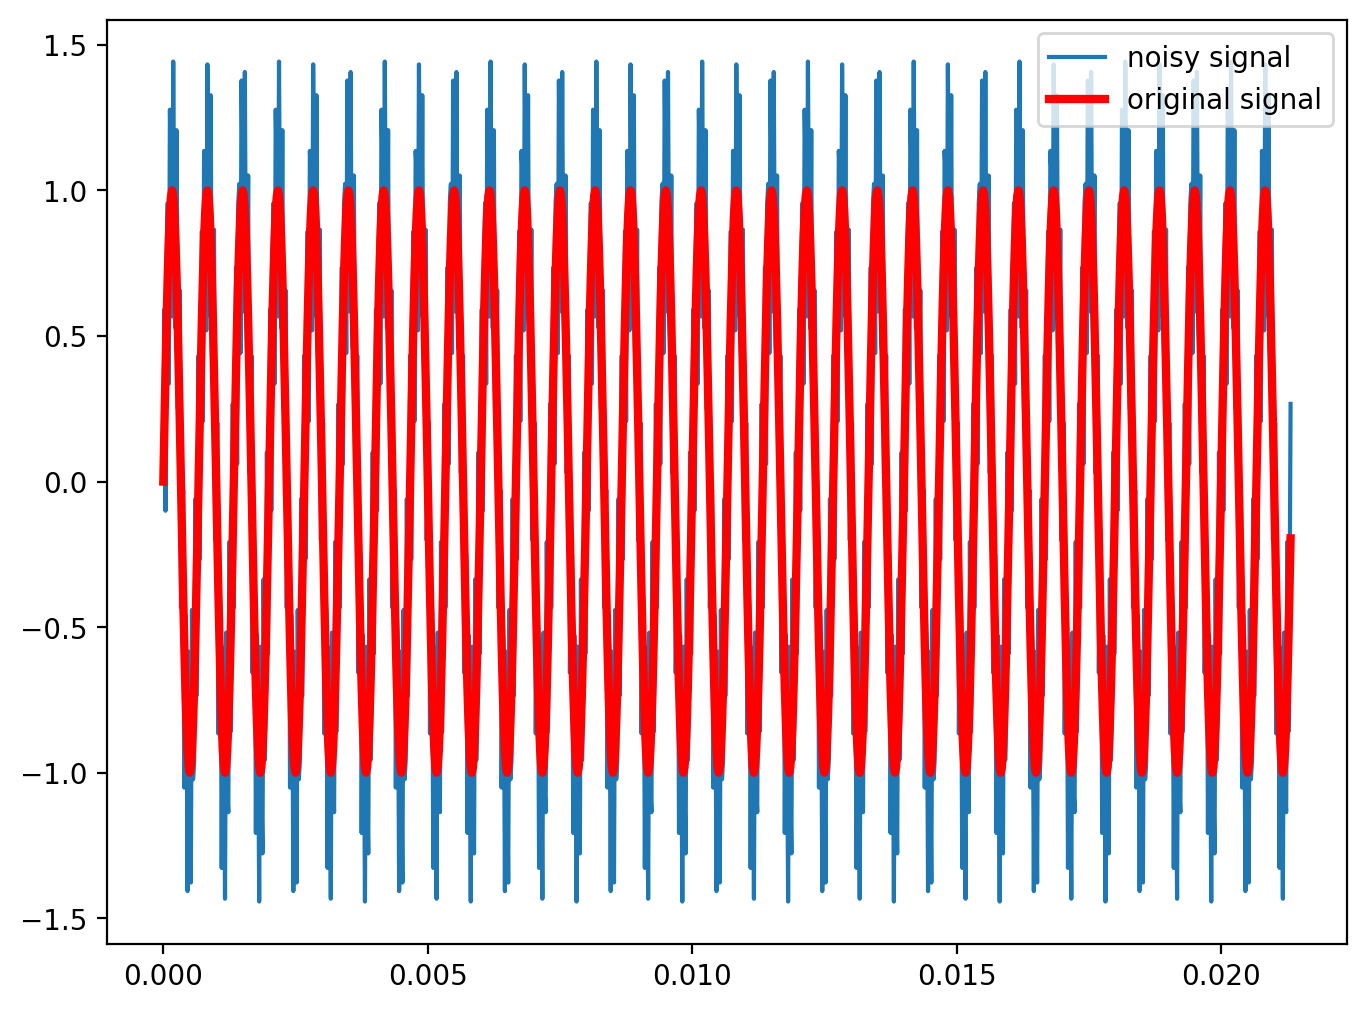

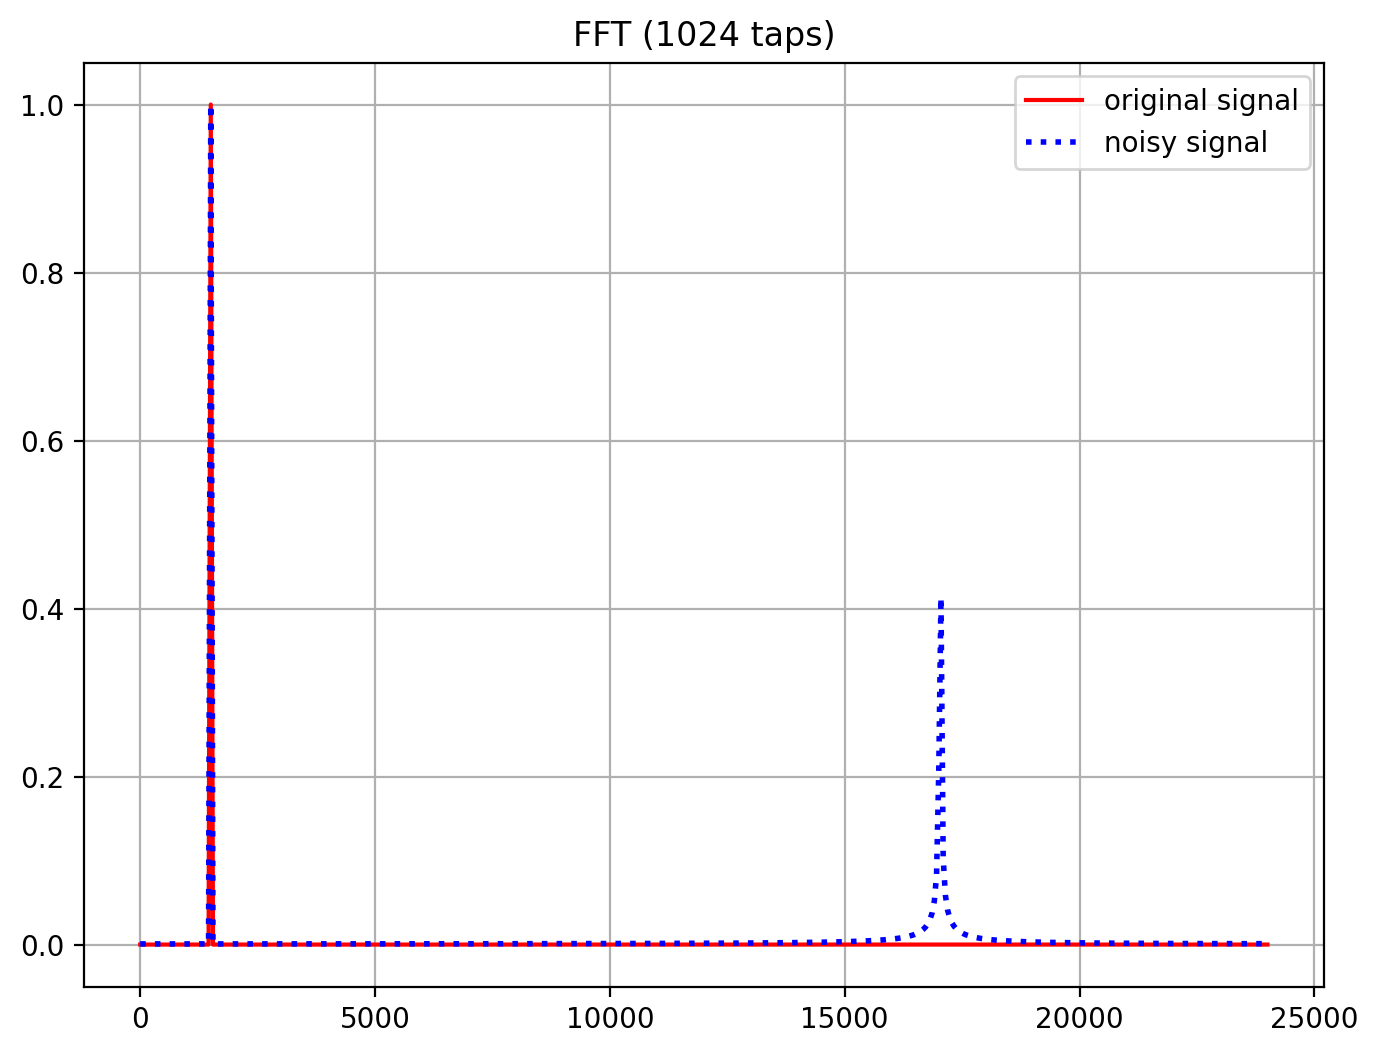

In [3]:
#------------------------------------------------
# Plot signals
#------------------------------------------------
figure(1, figsize=(8, 6), dpi=200)
# Plot the noisy signal and original signal
plot(t, signal_gen, label='noisy signal')
plot(t, data, 'r-', linewidth=3, label='original signal') 
legend()

# FFT PLOT
figure(2, figsize=(8, 6), dpi=200)
title('FFT (%d taps)' % NFFT)
plot(xfft,2.0/NFFT * np.abs(fft_signal[0:NFFT//2]),'r-', label='original signal')
plot(xfft,2.0/NFFT * np.abs(fft_signal_gen[0:NFFT//2]),'b:' ,linewidth=2, label='noisy signal')
legend()
grid(True)
show()

In [19]:
#------------------------------------------------
# Create a FIR filter and apply it to signal.
#------------------------------------------------
# The Nyquist rate of the signal.
nyq_rate = sample_rate / 2.
 
# The cutoff frequency of the filter: 6KHz
cutoff_hz = 10000.0
 
# Length of the filter (number of coefficients, i.e. the filter order + 1)
numtaps = 3  #15
 
# Use firwin to create a lowpass FIR filter
fir_coeff = firwin(numtaps, cutoff_hz/nyq_rate)
 
# Use lfilter to filter the signal with the FIR filter
filtered_signal = lfilter(fir_coeff, 1.0, signal_gen)

# FFT
fft_filtered_signal = fft(filtered_signal,NFFT)


# Filter Response
w, h = signal.freqz(fir_coeff)

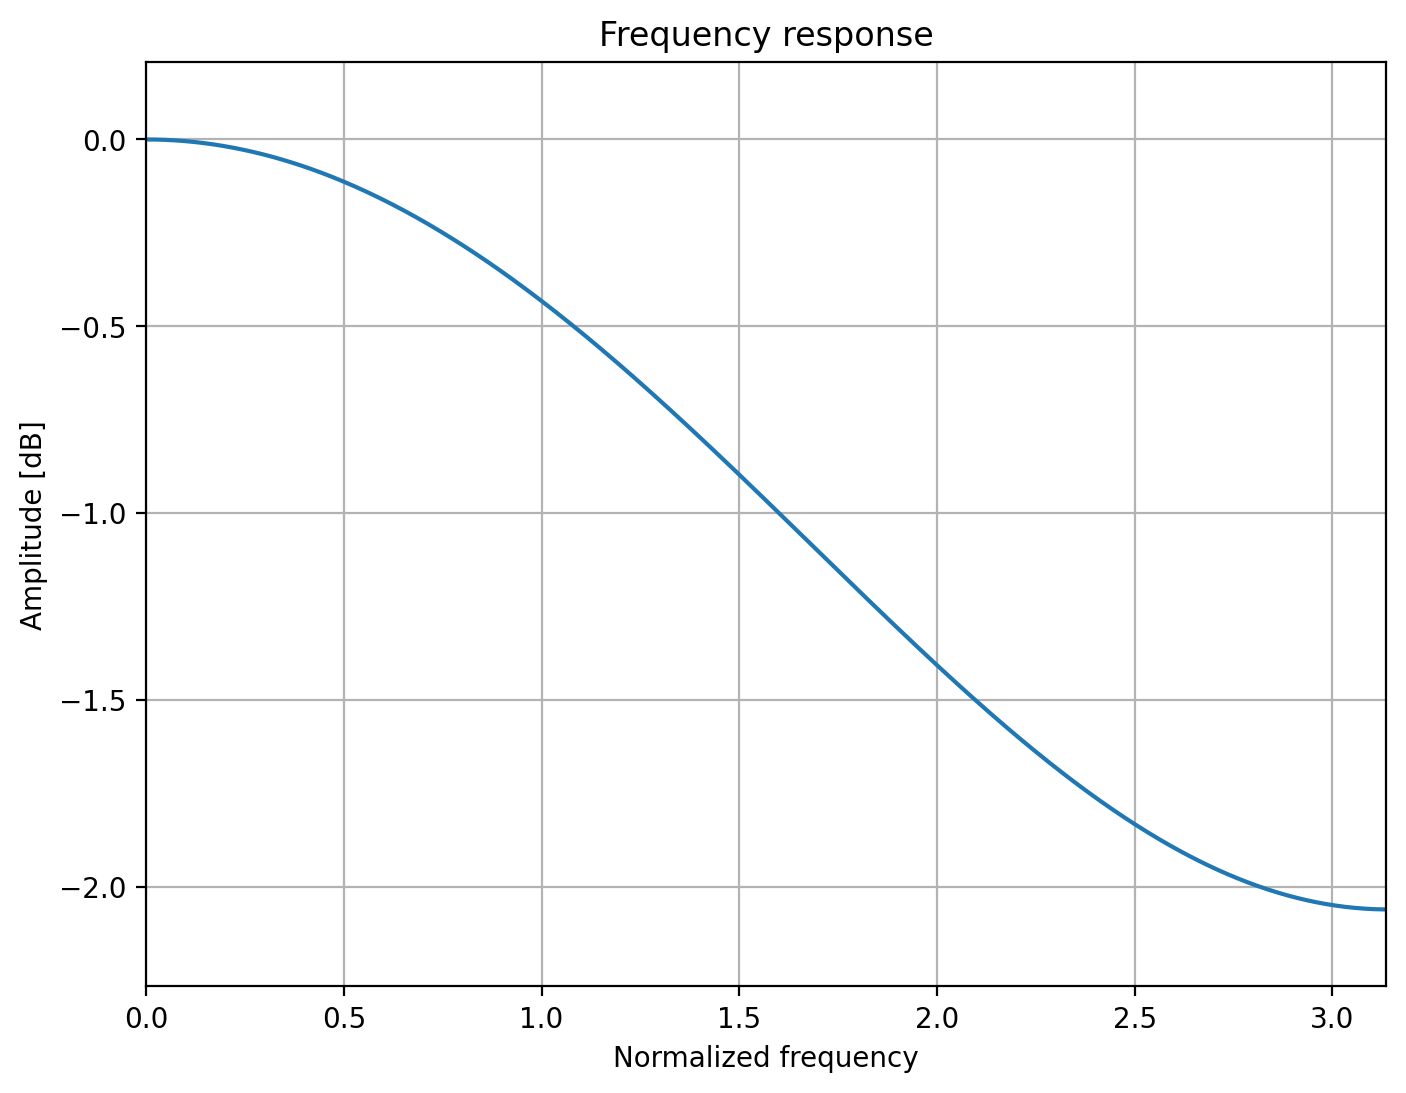

In [20]:
plt.figure(1, figsize=(8, 6), dpi=200)

plt.title('Frequency response')
plt.xlabel('Normalized frequency')
plt.ylabel('Amplitude [dB]')
plt.margins(0, 0.1)
plt.grid(True, color = '0.7', linestyle='-', which='major', axis='both')
plt.grid(True, color = '0.9', linestyle='-', which='minor', axis='both')
plt.plot(w, 20*log10(abs(h)))
plt.show()


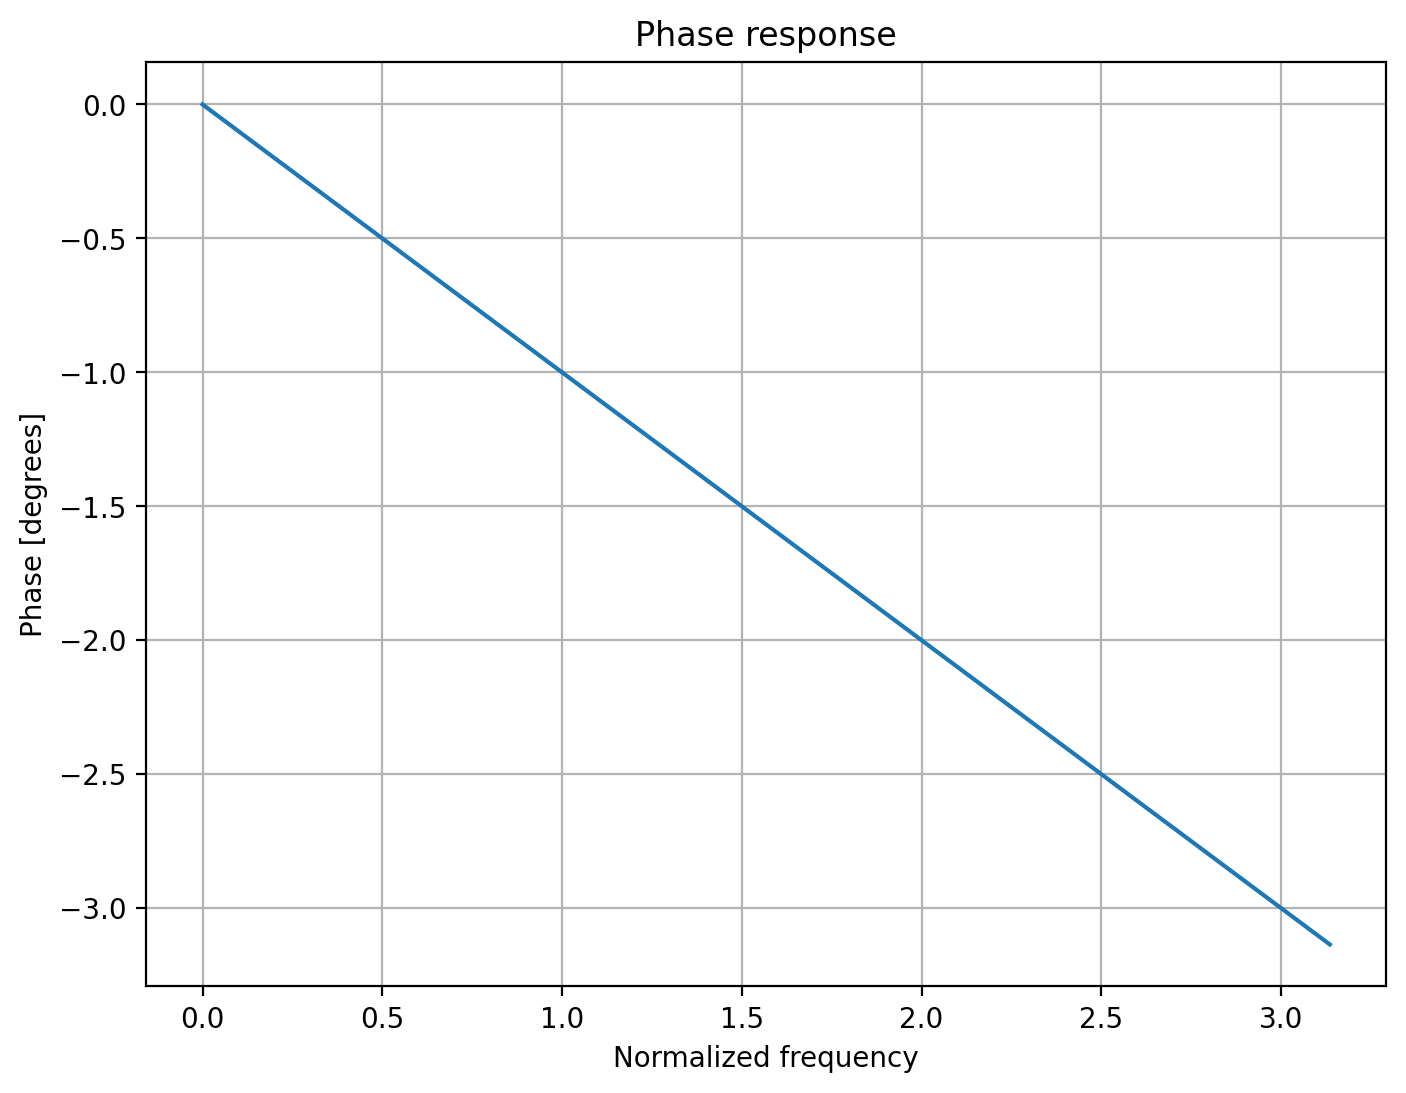

In [21]:
plt.figure(1, figsize=(8, 6), dpi=200)

plt.title('Phase response')
plt.xlabel('Normalized frequency')
plt.ylabel('Phase [degrees]')
plt.grid(True, color = '0.7', linestyle='-', which='major')
plt.grid(True, color = '0.9', linestyle='-', which='minor')
plt.plot(w, unwrap(angle(h)))
show()



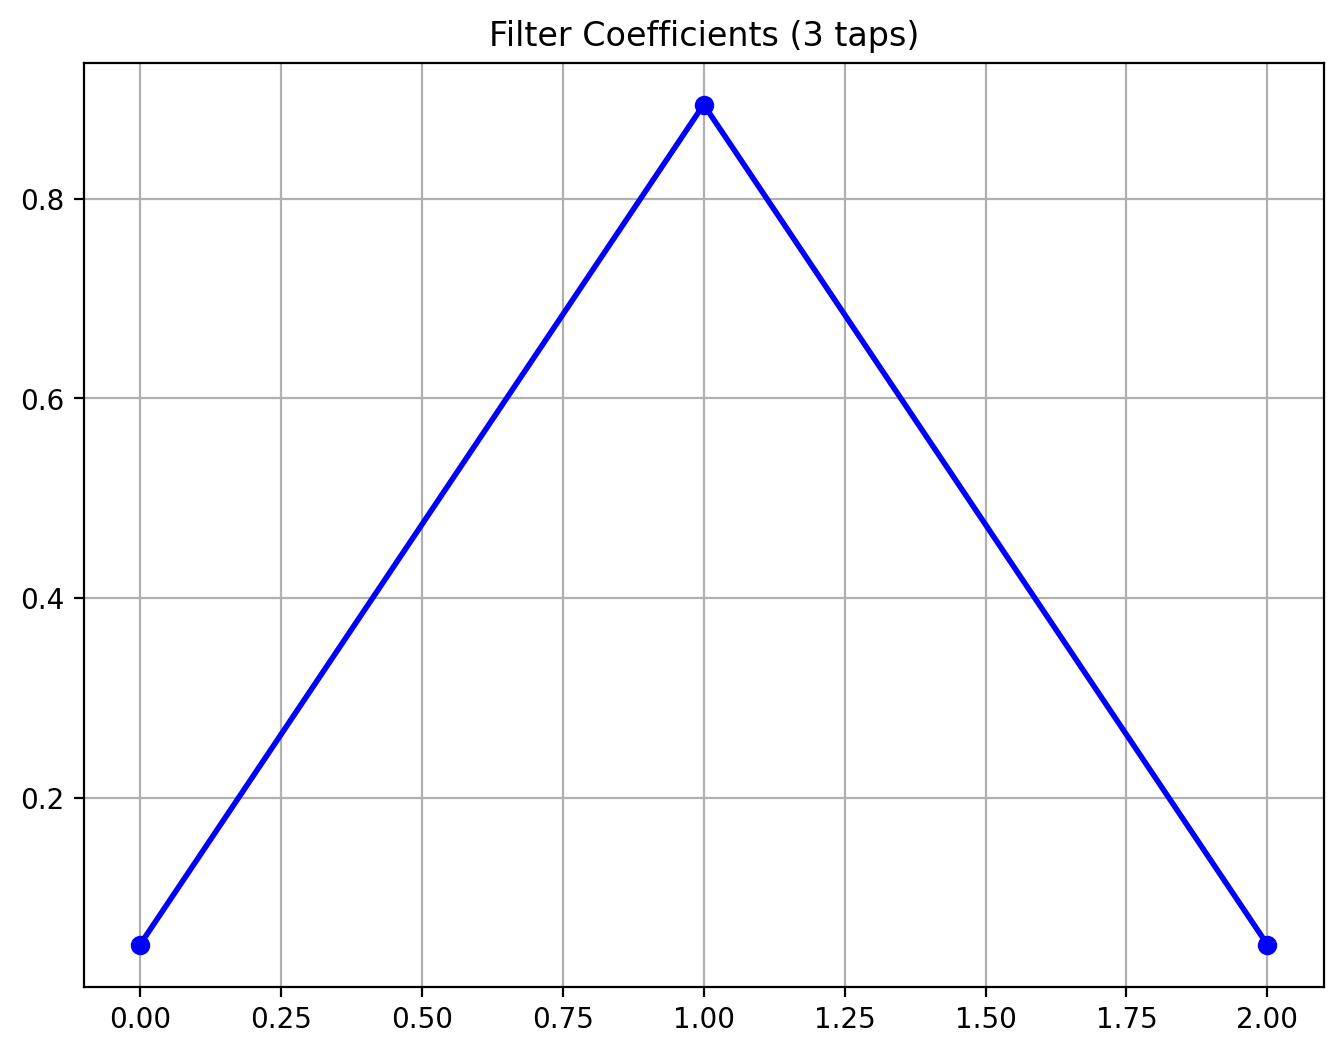

In [22]:
#------------------------------------------------
# Plot the FIR filter coefficients.
#------------------------------------------------
figure(1, figsize=(8, 6), dpi=200)
plot(fir_coeff, 'bo-', linewidth=2)
title('Filter Coefficients (%d taps)' % numtaps)
grid(True)

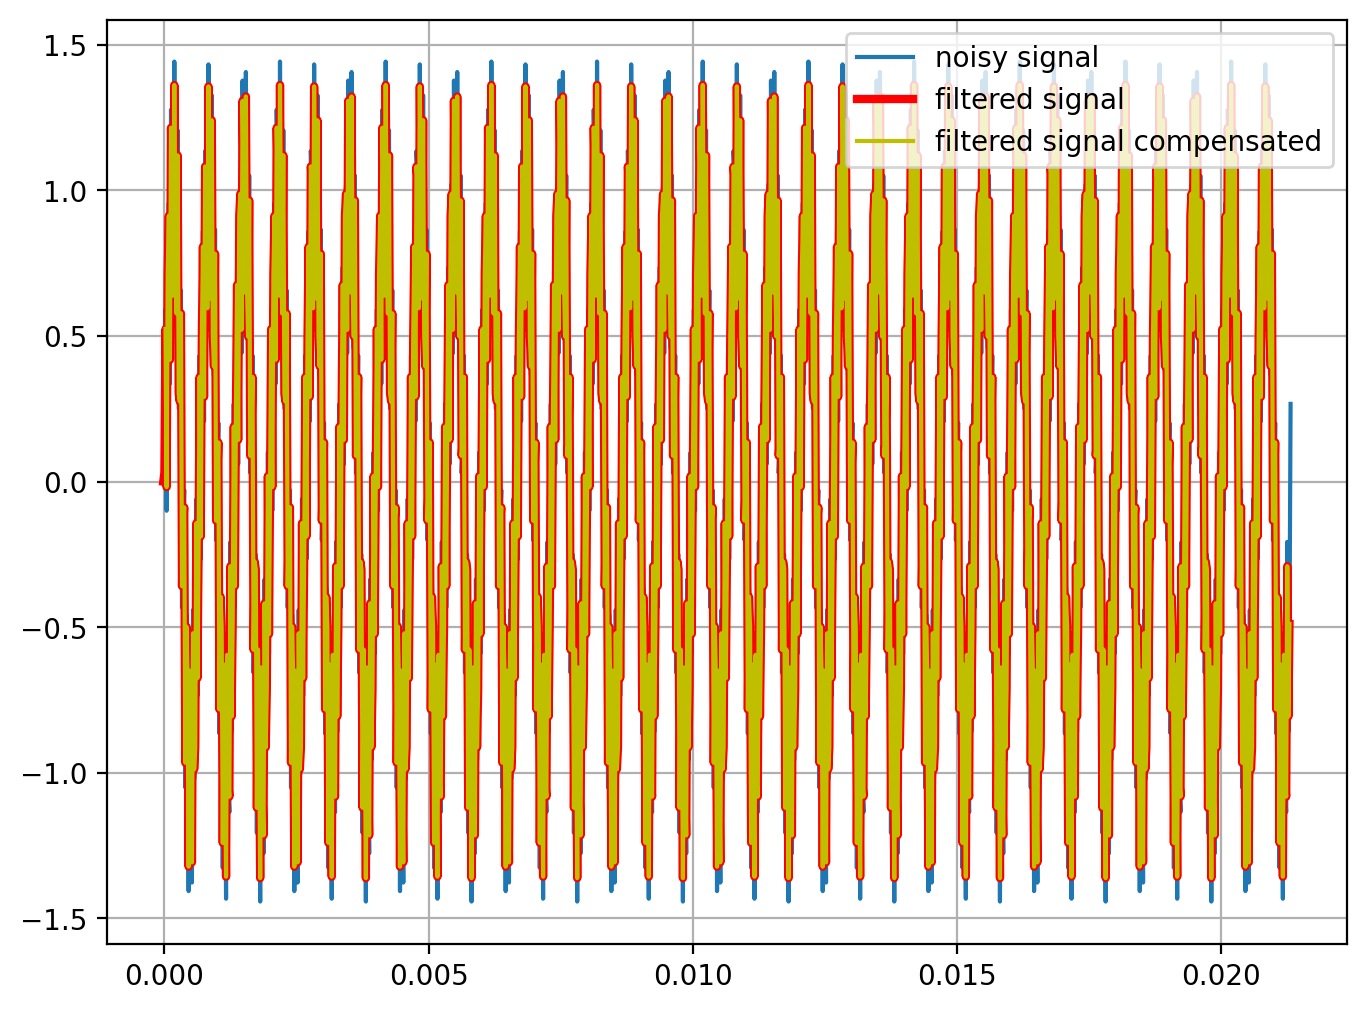

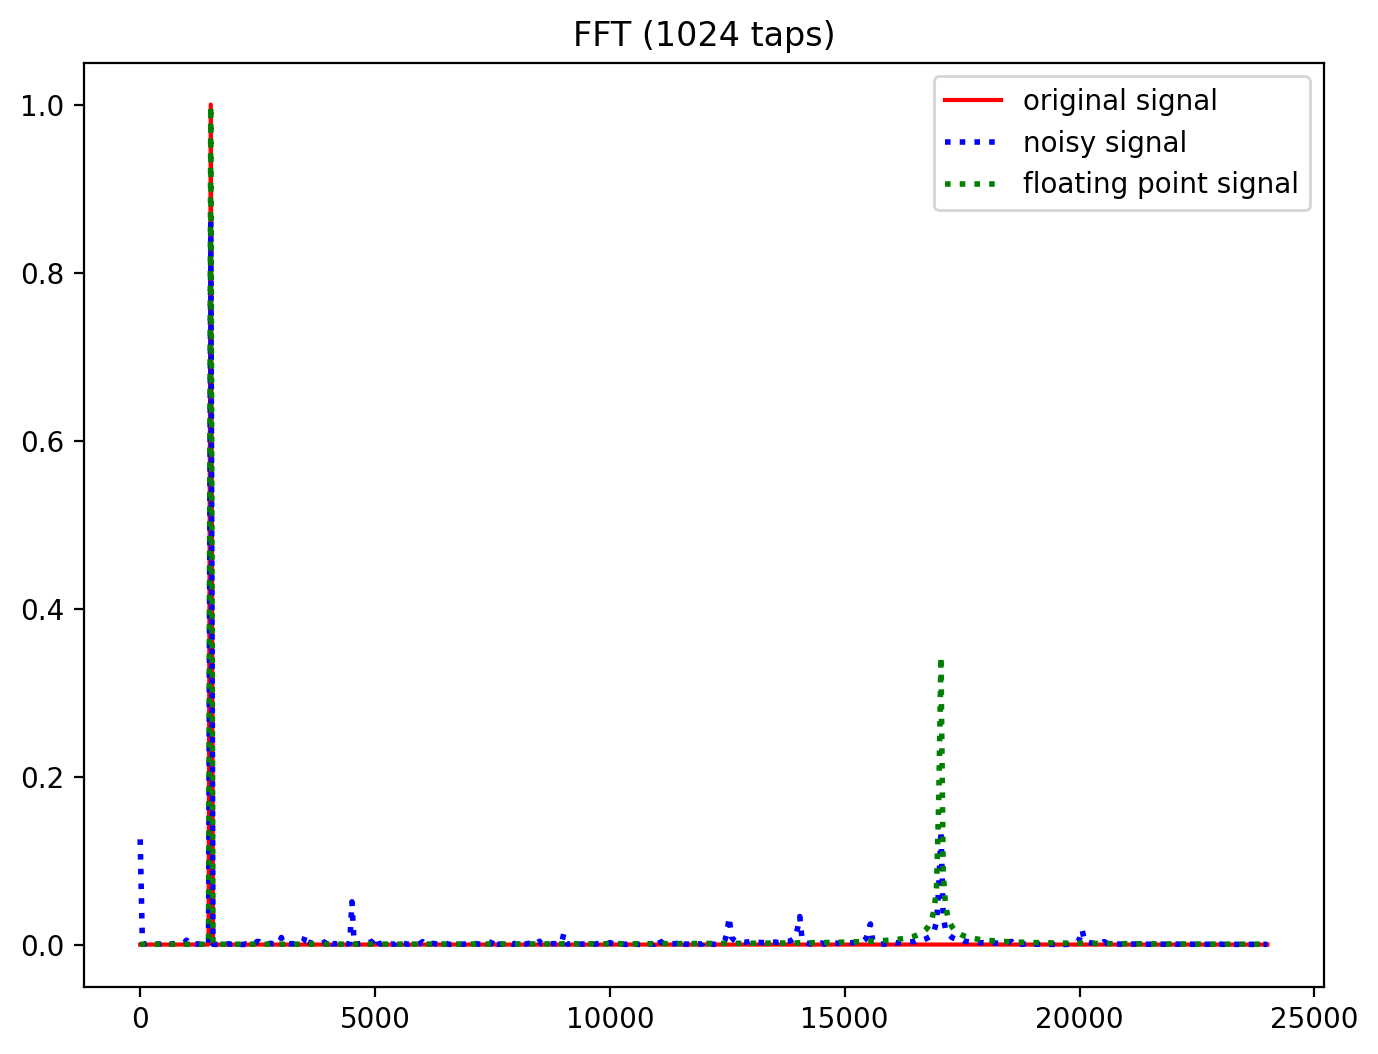

In [23]:
#------------------------------------------------
# Plot the original and filtered signals.
#------------------------------------------------
 
# The first N-1 samples are "corrupted" by the initial conditions
warmup = numtaps - 1
 
# The phase delay of the filtered signal
delay = (warmup / 2) / sample_rate
 
figure(1, figsize=(8, 6), dpi=200)
# Plot the original signal
plot(t, signal_gen, label='noisy signal')
 
# Plot the filtered signal, shifted to compensate for the phase delay
plot(t-delay, filtered_signal, 'r-', linewidth=3 , label='filtered signal')
 
# Plot just the "good" part of the filtered signal.  The first N-1
# samples are "corrupted" by the initial conditions.
plot(t[warmup:]-delay, filtered_signal[warmup:], 'y', label='filtered signal compensated')

legend()

grid(True)


# FFT PLOT
figure(2, figsize=(8, 6), dpi=200)
title('FFT (%d taps)' % NFFT)
plot(xfft,2.0/NFFT * np.abs(fft_signal[0:NFFT//2]),'r-', label='original signal')
plot(xfft,2.0/NFFT * np.abs(fft_signal_gen[0:NFFT//2]),'b:' ,linewidth=2, label='noisy signal')
plot(xfft,2.0/NFFT * np.abs(fft_filtered_signal[0:NFFT//2]),'g:' ,linewidth=2, label='floating point signal')
legend()

show()

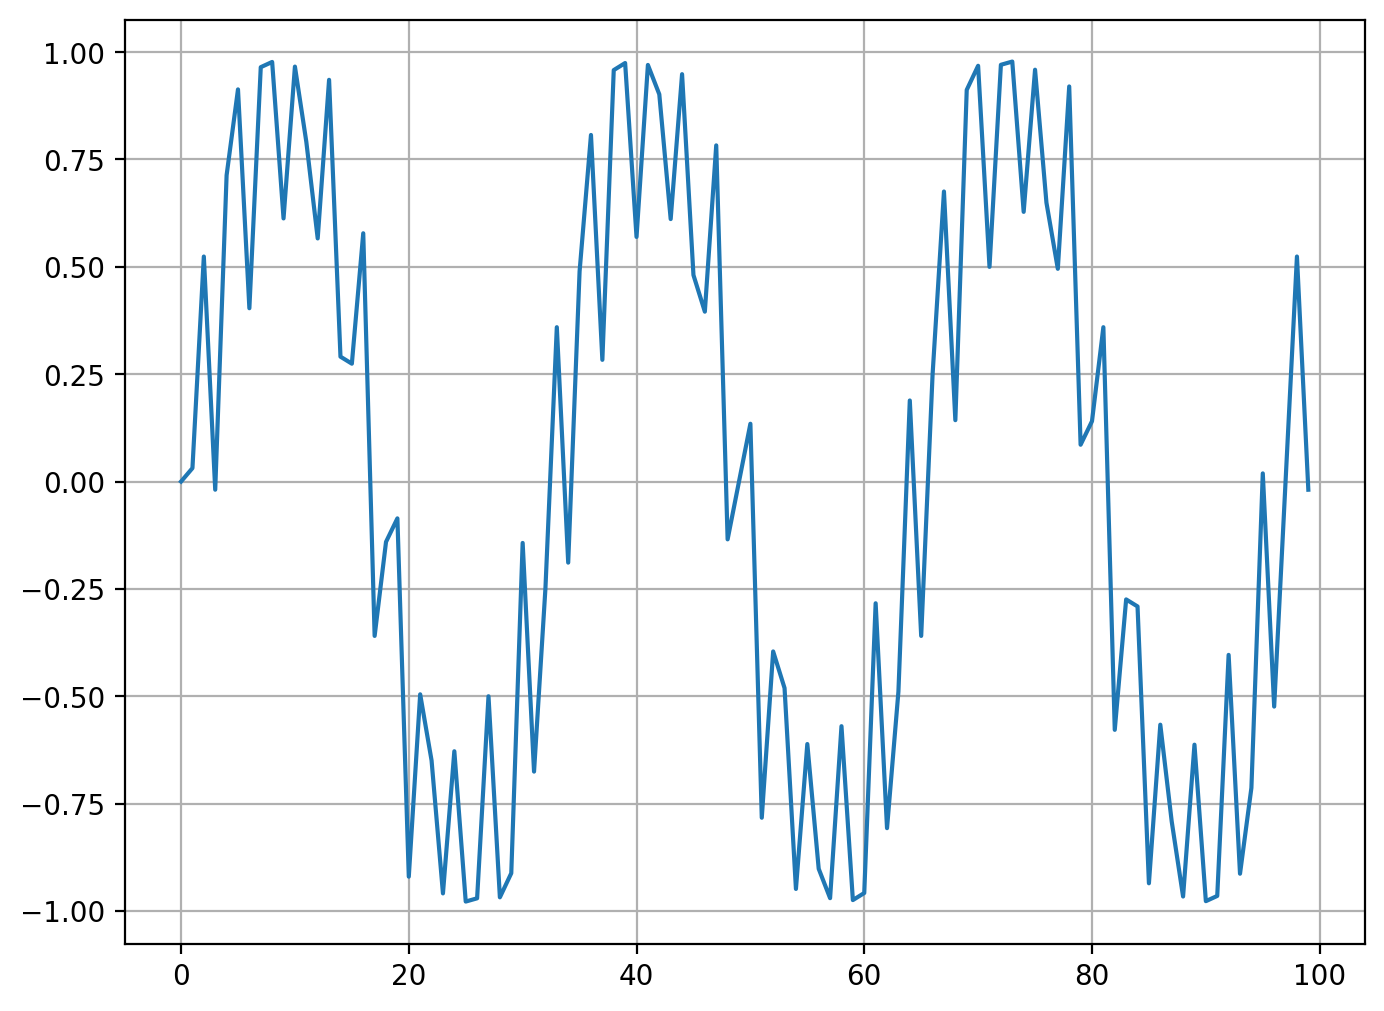

In [28]:
def fir_filter(x,c):
    Xn_Coeff = x * c
    fp_acumulador = Xn_Coeff[0]
    for index in range(1,len(Xn_Coeff)):
        fp_acumulador =  fp_acumulador + Xn_Coeff[index]
    return fp_acumulador


taps= len(fir_coeff)
init_coeff = np.ones(taps)

coeff = arrayFixedInt(16,15,fir_coeff)
xn =  arrayFixedInt(16,15,init_coeff)

value_coeff = [a.fValue for a in coeff]

fp_filtered = []
temp = [0.0]*taps

for value in signal_gen:
    temp.insert(0,value)
    temp.pop()
    for j in range(taps):
        xn[j].value = temp[j]
    Yn = fir_filter(xn,coeff)
    fp_filtered.append(Yn.fValue)
    
    
figure(1, figsize=(8, 6), dpi=200)
plot(fp_filtered[:100])

fft_signal_gen = fft(fp_filtered,NFFT)

# Filter Response
w, h = signal.freqz(value_coeff)

grid(True)

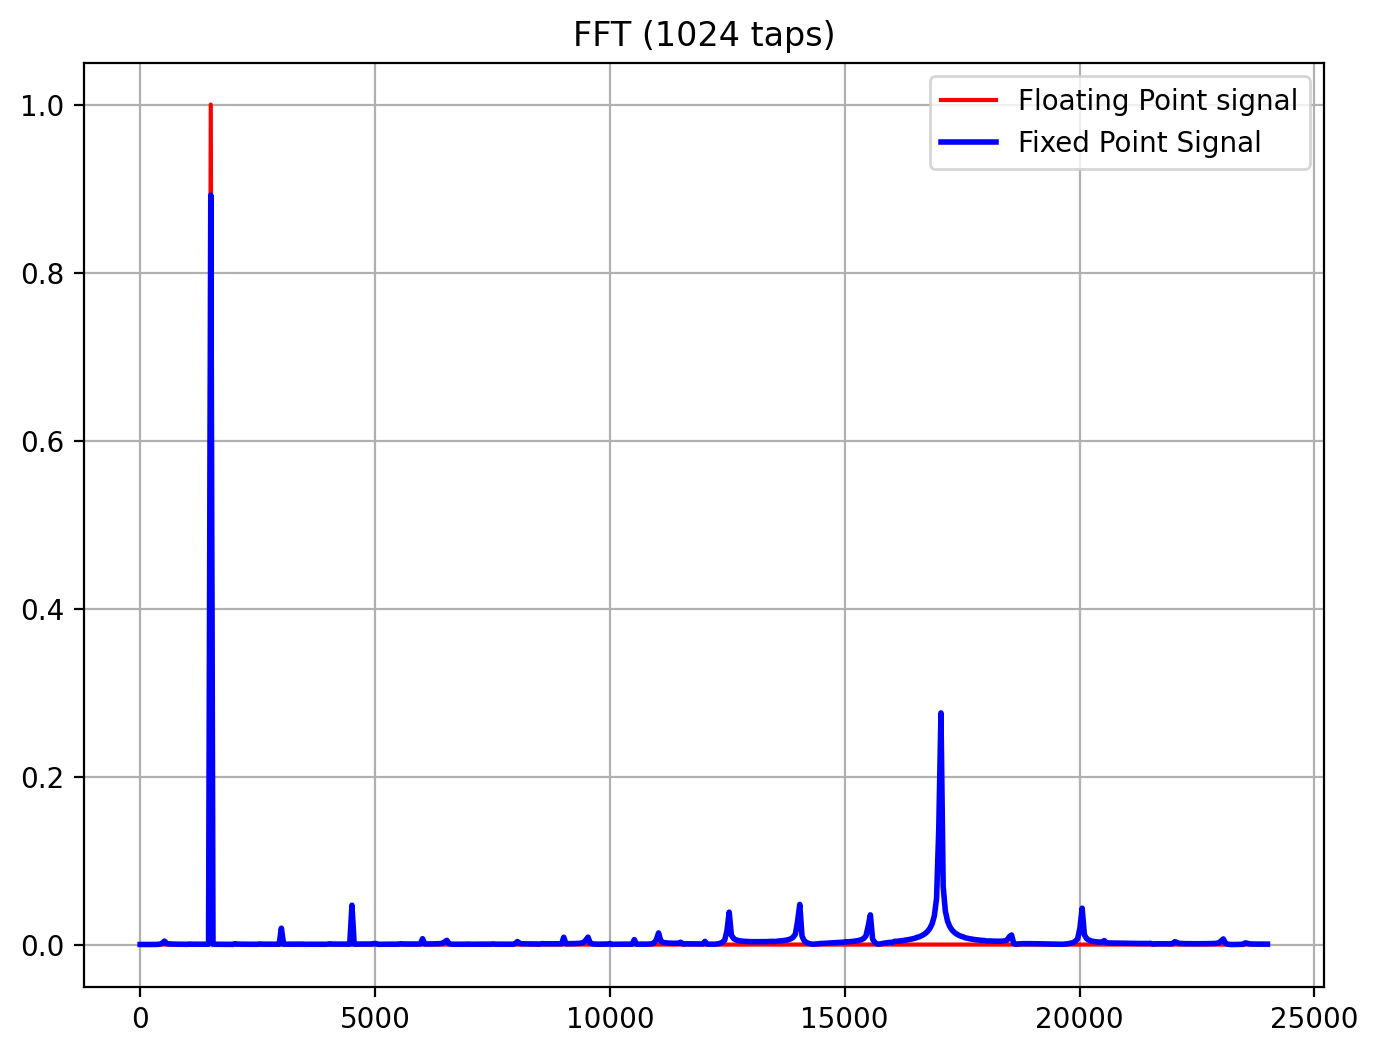

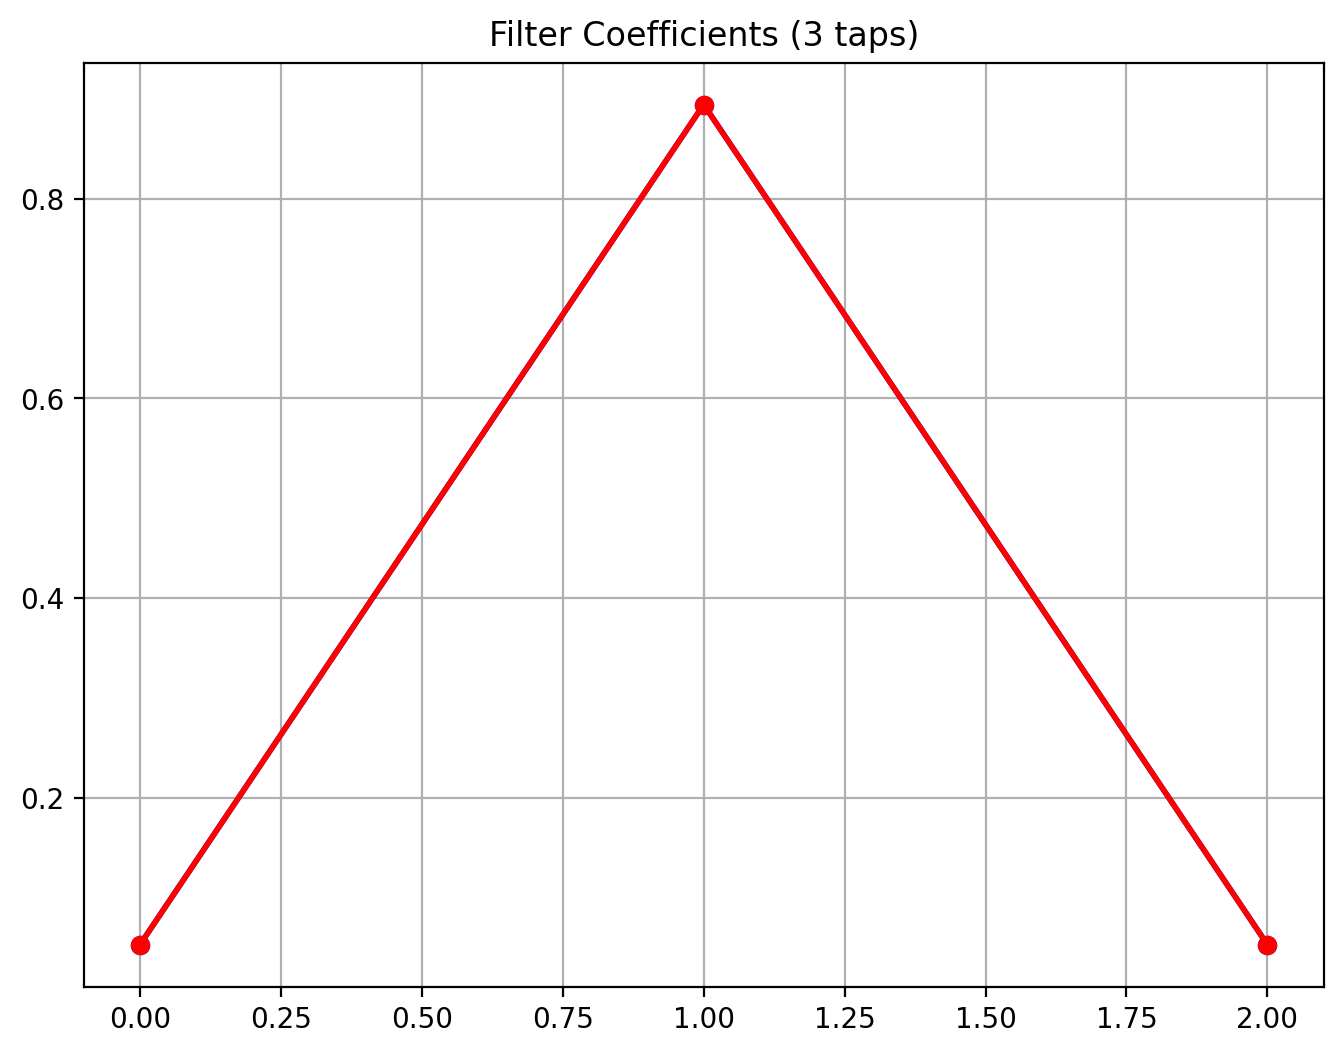

In [29]:
# FFT PLOT
figure(2, figsize=(8, 6), dpi=200)
title('FFT (%d taps)' % NFFT)
plot(xfft,2.0/NFFT * np.abs(fft_signal[0:NFFT//2]),'r-', label='Floating Point signal')
plot(xfft,2.0/NFFT * np.abs(fft_signal_gen[0:NFFT//2]),'b' ,linewidth=2, label='Fixed Point Signal')

legend()

grid(True)

#------------------------------------------------
# Plot the FIR filter coefficients.
#------------------------------------------------
figure(3, figsize=(8, 6), dpi=200)
plot(fir_coeff, 'bo-', linewidth=2, label='Floating Point FIR Coeff')
plot(value_coeff, 'ro-', linewidth=2, label='Fixed Point FIR Coeff')
title('Filter Coefficients (%d taps)' % numtaps)
grid(True)


show()


In [10]:
print(fir_coeff)

[0.03857901 0.46142099 0.46142099 0.03857901]


In [11]:
coeff

array([<1264 (0.039) S(16,15)>, <15119 (0.461) S(16,15)>,
       <15119 (0.461) S(16,15)>, <1264 (0.039) S(16,15)>], dtype=object)

In [30]:
[a.fValue for a in coeff]

[0.05279541015625, 0.894378662109375, 0.05279541015625]

In [31]:
[a.__hex__() for a in coeff]

['0x06C2', '0x727B', '0x06C2']